<a href="https://colab.research.google.com/github/maeng-gun/python_basic/blob/main/20%EB%85%84_%EC%99%B8%EB%B6%80%EC%9A%B4%EC%9A%A9_%EC%B6%94%EC%9D%B4_%EB%B0%8F_%EC%A0%9C%EB%8F%84%EA%B0%9C%EC%84%A0_%ED%9A%A8%EA%B3%BC_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 외부운용 시계열 분석  파이썬 코드

## 환경설정

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc, rcParams
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib_venn as ven
warnings.filterwarnings(action='ignore') 
rc('font', family='Malgun Gothic')
pd.options.display.float_format = '{:,.0f}'.format
rcParams['axes.unicode_minus']=False

## 기초자료 변수설정

In [ ]:
# 잔액 로데이터 생성
balance_raw = pd.read_pickle('dataset(2010-01-31 ~ 2020-10-21).df', compression='gzip')
basedate_index = pd.Series(balance_raw.보유일자.unique())


#부실유가증권 재분류
insolv = ['현대상선(주)', '(주)웅진', '웅진에너지(주)', '(주)동부메탈', '루카스(주)',
          '(주)팬택자산관리','신재생엔에이치제삼차(유)', '신재생엔에이치제육차(유)']
cond_normal = (~balance_raw.발행회사.isin(insolv)) & (~balance_raw.종목명.str.contains('대신느티나무', regex=False))
balance_raw.loc[cond_normal,'부실여부']='정상유가증권'
balance_raw.loc[~cond_normal,'부실여부']='부실유가증권'
balance_raw.loc[:,'과목'] = balance_raw.loc[:,'과목'].where(cond_normal,'부실유가증권')


#기준일자 지정
data = balance_raw.loc[(balance_raw.보유일자 > '2018-12-31'),:]
data.loc[:,'보유일자']= data.loc[:,'보유일자'].str[:7]

# 채권 로데이터 생성
bond = data.loc[(data.과목=='채권')&(data.부실여부=='정상유가증권'),:]
bond.loc[:,'상품종류'] = bond.loc[:,'상품종류'].replace({'금융채':'회사채', '금융채(특금)':'회사채', '회사채(특금)':'회사채',
                                                '농금채' : '회사채', '국채':'국공채', '지방채':'국공채','공사채':'국공채',
                                                '국채(첨가)':'국공채','국채(특금)':'국공채'})
bond_cor = bond.loc[(bond.상품종류=='회사채'),:]

# 거래내역 로데이터 생성
trade_raw = pd.read_csv('2019년 이후 매입 거래내역.csv',thousands=',',na_values='')
trade_raw = trade_raw.iloc[:,1:36]
trade_raw.loc[:,'매입월'] =  trade_raw.loc[:,'거래일자'].str[:7]
trade = trade_raw.loc[(trade_raw.과목=='채권'),:]
balance_raw

,지역본부,시군지부,사무소명,사무소코드,과목,상품종류,표준코드,계좌번호,종목명,자산구분,...,시장수익율,발행회사,거래회사,농축협예수사무소코드,평가손익,매입신용등급,계속보유여부검토대상,매입수익률*장부금액,보유일자,부실여부
0,서울,서울지역본부,영동농협,100012,대내외예치금,농축협예치금,DA1000120002,100012-134-000110,정기예탁금(대호지농협),기타유가,...,7,농축협공통,농축협공통,481043,0,NaN,NaN,49,2010-01-31,정상유가증권
1,서울,서울지역본부,영동농협,100012,대내외예치금,농축협예치금,DA1000120003,100012-134-000123,정기예탁금(신평농협),기타유가,...,7,농축협공통,농축협공통,481102,0,NaN,NaN,174,2010-01-31,정상유가증권
2,서울,서울지역본부,영동농협,100012,대내외예치금,농축협예치금,DA1000120004,100012-134-000137,정기예탁금(대호지농협),기타유가,...,7,농축협공통,농축협공통,481043,0,NaN,NaN,48,2010-01-31,정상유가증권
3,서울,서울지역본부,영동농협,100012,대내외예치금,농축협예치금,DA1000120005,100012-134-000141,정기예탁금(옹진농협),기타유가,...,7,농축협공통,농축협공통,216034,0,NaN,NaN,150,2010-01-31,정상유가증권
4,서울,서울지역본부,영동농협,100012,대내외예치금,농축협예치금,DA1000120006,100012-134-000154,정기예탁금(가평축산농협),기타유가,...,7,농축협공통,농축협공통,172006,0,NaN,NaN,158,2010-01-31,정상유가증권
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800492,제주,제주시지부,제주시농협,901018,대내외예치금,농축협예치금,DA9010180047,901018-134-000786,정기예탁금 (애월농협),기타유가,...,6,농축협공통,농축협공통,"901,125",0,NaN,NaN,82,2020-10-21,정상유가증권
800493,제주,제주시지부,제주시농협,901018,대내외예치금,농축협예치금,DA9010180048,901018-134-000790,정기예탁금 (회천농협),기타유가,...,6,농축협공통,농축협공통,"621,047",0,NaN,NaN,42,2020-10-21,정상유가증권
800494,제주,서귀포시지부,대정농협,903013,채권,회사채,KR6117931263,903013-134-000348,한진해운76-2,매도가능,...,6,(주)한진해운,유안타증권(주),NaN,0,A-,NaN,0,2020-10-21,정상유가증권
800495,제주,서귀포시지부,안덕농협,903024,부실유가증권,자산유동화기업어음(ABCP),CP0000021581,903024-134-000181,루카스ABCP,만기보유,...,6,루카스(주),엔에이치투자증권(주),NaN,0,A2,NaN,0,2020-10-21,부실유가증권


## 1. 외부운용 총액 추이

### 1) 자산별

과목,채권,대내외예치금,수익증권,부실유가증권
보유일자,,,,
2019-01,"12,294","6,991","1,513","1,276"
2019-02,"12,369","6,819","1,416","1,276"
2019-03,"11,348","7,116","1,416","1,276"
2019-04,"10,837","7,252","1,410","1,199"
2019-05,"10,670","7,142","1,364","1,199"
2019-06,"10,047","6,873","1,414","1,199"
2019-07,"9,381","6,522","1,394","1,126"
2019-08,"9,038","6,428","1,344","1,126"
2019-09,"9,168","5,902","1,339","1,126"


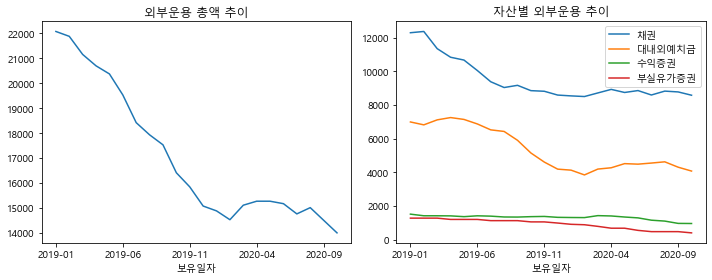

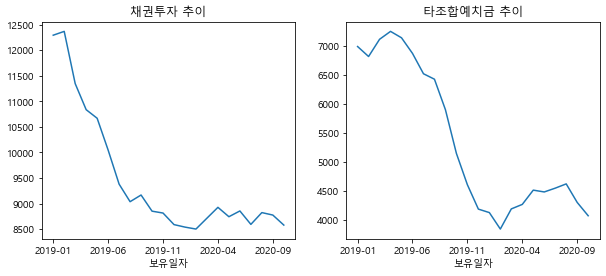

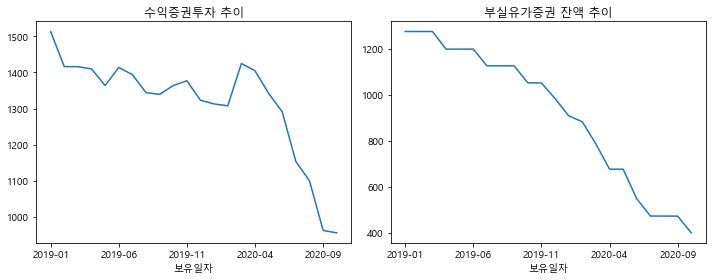

In [ ]:
sort = ['채권','대내외예치금','수익증권','부실유가증권']
total = data.pivot_table(index='과목',columns='보유일자',values='장부금액',aggfunc='sum').T.loc[:,sort]


fig1 = plt.figure(figsize=(10,4))
ax0 = fig1.add_subplot(1,2,1)
ax1 = fig1.add_subplot(1,2,2)
total.sum(axis=1).plot(ax=ax0, title = '외부운용 총액 추이')
total.plot(ax=ax1, title='자산별 외부운용 추이')
plt.legend()
plt.tight_layout()
fig2 = plt.figure(figsize=(10,4))
ax2 = fig2.add_subplot(1,2,1)
ax3 = fig2.add_subplot(1,2,2)
total[['채권']].plot(ax=ax2, legend=False, title='채권투자 추이')
total[['대내외예치금']].plot(ax=ax3, legend=False, title='타조합예치금 추이')
fig2 = plt.figure(figsize=(10,4))
ax4 = fig2.add_subplot(1,2,1)
ax5 = fig2.add_subplot(1,2,2)
total[['수익증권']].plot(ax=ax4, legend=False, title='수익증권투자 추이')
total[['부실유가증권']].plot(ax=ax5, legend=False, title='부실유가증권 잔액 추이')
plt.tight_layout()
total

### 2) 세부분류별

상품종류,국공채,회사채
보유일자,,
2019-01,843,"11,451"
2019-02,877,"11,492"
2019-03,836,"10,512"
2019-04,788,"10,049"
2019-05,732,"9,938"
2019-06,607,"9,440"
2019-07,475,"8,907"
2019-08,530,"8,507"
2019-09,620,"8,548"


과목         수익증권        
상품종류    채권형수익증권 혼합형수익증권
보유일자                   
2019-01     249   1,264
2019-02     173   1,244
2019-03     173   1,243
2019-04     173   1,237
2019-05     173   1,191
2019-06     173   1,241
2019-07     173   1,221
2019-08     173   1,172
2019-09     173   1,167
2019-10     173   1,191
2019-11     173   1,204
2019-12     177   1,146
2020-01     177   1,136
2020-02     187   1,121
2020-03     187   1,238
2020-04     187   1,218
2020-05     237   1,105
2020-06     227   1,064
2020-07     275     879
2020-08     375     726
2020-09     225     738
2020-10     275     682

부실종목,(주)동부메탈,kteng,기타,현대상선(주)
보유일자,,,,
2019-01,261,168,184,661
2019-02,261,168,184,661
2019-03,261,168,184,661
2019-04,261,168,183,586
2019-05,261,168,183,586
2019-06,261,168,183,587
2019-07,261,168,183,514
2019-08,261,168,183,514
2019-09,261,168,183,514


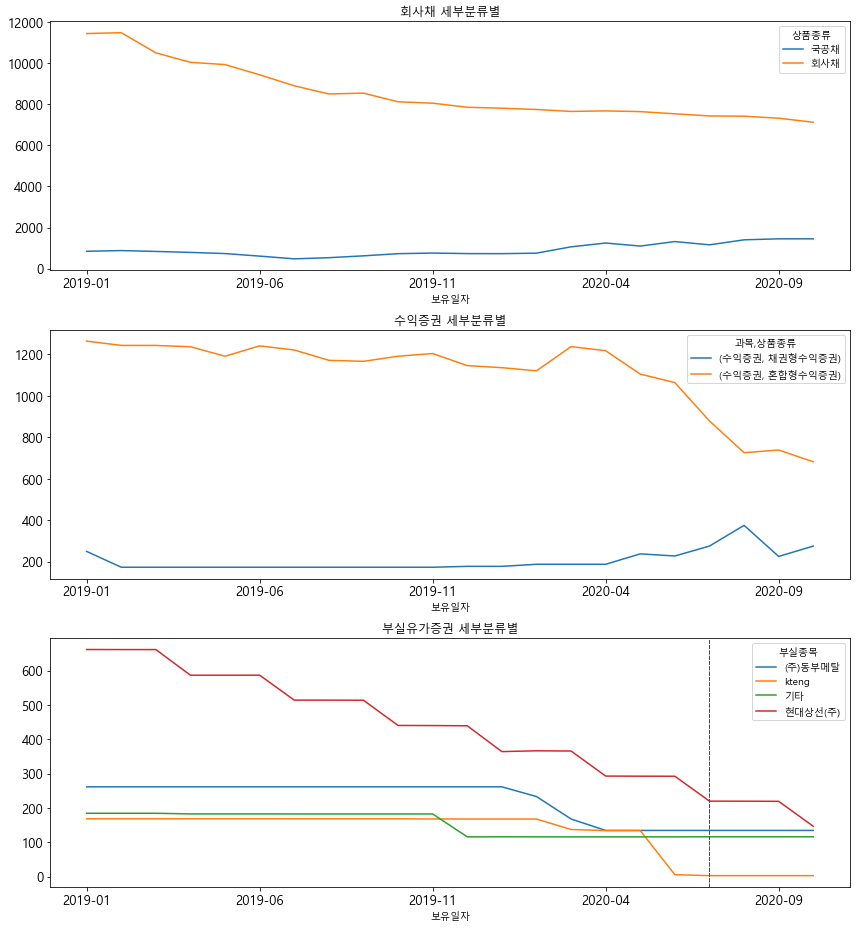

In [ ]:
bs = pd.read_csv('2016년 이후 농축협 재무상태 시계열.csv',thousands=',',na_values='').iloc[:,1:]
bs['대외예치금'] = bs['타조합예치금'] + bs['타금융기관예치금']
col  = ['보유일자','정기예치금', '일시예치금', '상호대출금합계', '예수금합계', '상호차입금합계']
bs = bs.loc[:,col]
col2 = ['보유일자','정기예치', '일시예치', '대출금', '예수금', '상호차입금']
bs.columns = col2
bs_p = bond.pivot_table(index='보유일자',columns='상품종류',values='장부금액',aggfunc='sum',fill_value=0)

fund = data[data.상품종류.isin(['혼합형수익증권', '채권형수익증권', '채권형수익증권(특금)'])& ~(data.과목=='부실유가증권')]
fund.loc[:,'상품종류']=fund.loc[:,'상품종류'].replace('채권형수익증권(특금)','채권형수익증권')
fund_p = fund.pivot_table(index='보유일자',columns=['과목','상품종류'],values='장부금액',aggfunc='sum',fill_value=0)

sol = data[data.과목=='부실유가증권']
sol.loc[:,'부실종목'] = sol.loc[:,'발행회사'].replace({'신재생엔에이치제삼차(유)':'kteng','루카스(주)':'kteng','신재생엔에이치제육차(유)':'kteng','웅진에너지(주)':'기타', '(주)웅진':'기타','(주)팬택자산관리':'기타','대신자산운용(주)':'기타'})
sol_p = sol.pivot_table(index='보유일자',columns='부실종목',values='장부금액',aggfunc='sum',fill_value=0)
fig2 = plt.figure(figsize=(10,20))
ax2 = fig2.add_subplot(3,1,1)
ax3 = fig2.add_subplot(3,1,2)
ax4 = fig2.add_subplot(3,1,3)
display(bs_p)
display(fund_p)
display(sol_p)
bs_p.plot(title='회사채 세부분류별',figsize=(12,13),fontsize=13, ax=ax2)
plt.axvline(x=18, color='r',linestyle='--',linewidth=1)
fund_p.plot(title='수익증권 세부분류별',figsize=(12,13),fontsize=13, ax=ax3)
plt.axvline(x=18, color='r',linestyle='--',linewidth=1)
sol_p.plot(title='부실유가증권 세부분류별',figsize=(12,13),fontsize=13, ax=ax4)
plt.axvline(x=18, color='r',linestyle='--',linewidth=1)
plt.tight_layout()
plt.show()

## 2. 자산별 잔액 추이

### 1) 만기별

상품종류       국공채           회사채              
매입만기    10년 이하 30년 이하  3년 이하  5년 이하 10년 이하
보유일자                                      
2019-01    530    313    451  2,767  8,233
2019-02    530    347    381  2,735  8,376
2019-03    511    324    251  2,307  7,954
2019-04    451    336     81  1,944  8,024
2019-05    442    290     76  1,926  7,936
2019-06    382    225     66  1,852  7,523
2019-07    311    163     66  1,781  7,060
2019-08    311    219     56  1,760  6,691
2019-09    309    311     56  1,760  6,732
2019-10    360    366     61  1,660  6,406
2019-11    391    366     81  1,629  6,349
2019-12    374    356     70  1,626  6,163
2020-01    384    343     70  1,575  6,168
2020-02    374    378     70  1,555  6,125
2020-03    433    627     76  1,530  6,050
2020-04    463    782    204  1,501  5,978
2020-05    381    715    291  1,478  5,878
2020-06    381    934    340  1,385  5,816
2020-07    351    806    350  1,368  5,719
2020-08    595    806    431  1,368  5,625
2020-09    644    806    421  1,342  5,563
2020-10    744    706    332  1,357  5,441

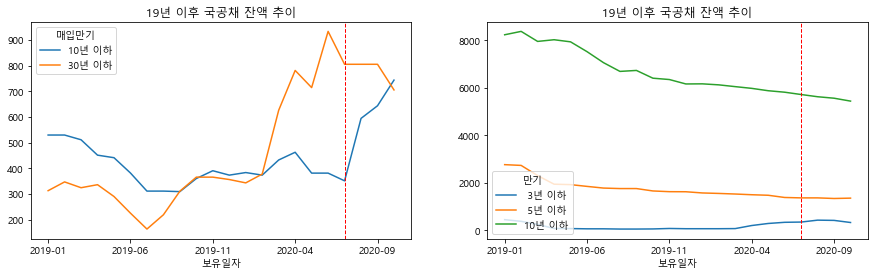

In [ ]:
# '만기'컬럼이 추가된 채권 데이터 생성

x=pd.to_datetime(bond.loc[:,'만기일'])
y=pd.to_datetime(bond.loc[:,'발행일'])
z=pd.to_datetime(bond.loc[:,'매입일'])
j=x-y
k=x-z
bond.loc[:,'발행만기']=round(j/np.timedelta64(1,'Y'))
bond.loc[:,'매입만기']=round(k/np.timedelta64(1,'Y'))

comm_gov = bond.loc[:,'상품종류'] == '국공채'
comm_cor = bond.loc[:,'상품종류'] == '회사채'

dur_10_b = (bond.매입만기<=10)
dur_10_a = (bond.매입만기>10)

dur_3_b = (bond.매입만기<=3)
dur_3_5 = (bond.매입만기>3) & (bond.매입만기<=5)
dur_5_a = (bond.매입만기>5)

bond.loc[dur_10_b & comm_gov,'매입만기']='10년 이하'
bond.loc[dur_10_a & comm_gov,'매입만기']='30년 이하'

bond.loc[dur_3_b & comm_cor,'매입만기']=' 3년 이하'
bond.loc[dur_3_5 & comm_cor,'매입만기']=' 5년 이하'
bond.loc[dur_5_a & comm_cor,'매입만기']='10년 이하'


bond_pivot = bond.pivot_table(index=['상품종류','매입만기'],columns='보유일자',fill_value=0, values='장부금액',aggfunc='sum')

fig = plt.figure(figsize=(15,4))
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)
bond_pivot.T['국공채'].plot(ax=ax0, title='19년 이후 국공채 잔액 추이')
ax0.axvline(x=18, color='r',linestyle='--',linewidth=1)
bond_pivot.T['회사채'].plot(ax=ax1, title='19년 이후 국공채 잔액 추이')
ax1.axvline(x=18, color='r',linestyle='--',linewidth=1)
plt.legend(title='만기', loc=3)
bond_pivot.T

### 2) 신용등급별

신용등급,A+ 이상,AA0 이상,A0 이하
보유일자,,,
2019-01,41.9,40.3,17.8
2019-02,42.5,40.0,17.5
2019-03,42.4,41.0,16.6
2019-04,43.1,42.5,14.4
2019-05,44.9,41.5,13.5
2019-06,44.3,42.2,13.5
2019-07,45.2,40.7,14.0
2019-08,46.2,40.3,13.6
2019-09,46.3,40.2,13.5


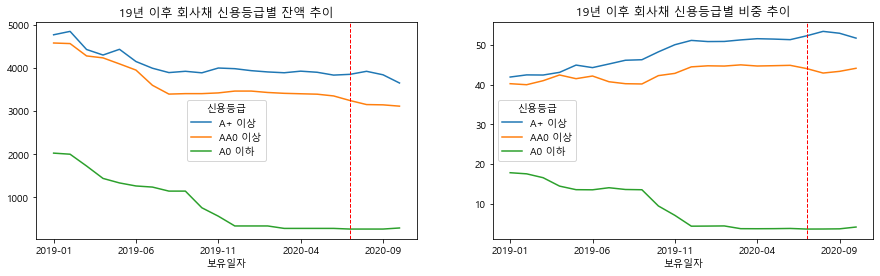

In [ ]:
pd.options.display.float_format = '{:,.1f}'.format
bond_cor = bond_cor[~(bond_cor.신용등급=='')]
bond_cor.loc[:,'신용등급'] = bond_cor.loc[:,'신용등급'].replace({'AAA':'AA0 이상', 'AA+':'AA0 이상', 'AA':'AA0 이상',
                                                                 'AA-':'A+ 이상','A+':'A+ 이상',
                                                                 'A':'A0 이하','A-':'A0 이하','BBB+':'A0 이하','BBB':'A0 이하'})

credit = bond_cor.pivot_table(index='신용등급',columns='보유일자',values='장부금액',aggfunc='sum',fill_value=0).T
credit = credit.loc[:,['A+ 이상','AA0 이상','A0 이하']]
credit.loc[:,'총계']=credit.sum(axis=1)
credit_r = pd.DataFrame()
for i in range(3):
    credit_r.loc[:,i]=credit.iloc[:,i] / credit.loc[:,'총계'] * 100
credit_r.columns= credit.iloc[:,:3].columns  
fig = plt.figure(figsize=(15,4))
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)
credit.iloc[:,:3].plot(title='19년 이후 회사채 신용등급별 잔액 추이',ax=ax0)
ax0.axvline(x=18, color='r',linestyle='--',linewidth=1)
credit_r.plot(title='19년 이후 회사채 신용등급별 비중 추이',ax=ax1)
ax1.axvline(x=18, color='r',linestyle='--',linewidth=1)
credit_r

## 3. 자산별 신규매입 추이

### 1) 만기별

상품종류       국공채            회사채               
매입만기    10년 이하  30년 이하  3년 이하  5년 이하  10년 이상
2019-01   10.7    22.7    0.0   20.1   105.3
2019-02   10.7    57.0    0.0   20.1   373.9
2019-03   10.7    68.3    0.0   20.1   429.5
2019-04   10.7    91.5    0.0   20.1   693.1
2019-05   10.7   126.6    0.0   20.1   875.4
2019-06   10.7   126.6    0.0   20.1   875.4
2019-07   10.7   214.3    0.0   20.1   916.1
2019-08   10.7   297.8    0.0   20.1   916.1
2019-09   10.7   389.8    0.0   20.1   987.1
2019-10   61.8   444.6   14.9   20.1   987.1
2019-11   92.1   465.7   34.9   40.3 1,075.2
2019-12   92.1   476.9   34.9   45.4 1,075.2
2020-01  102.1   476.9   34.9   45.4 1,090.3
2020-02  102.1   522.0   34.9   45.4 1,182.6
2020-03  161.2   803.9   55.2   45.4 1,225.2
2020-04  191.3   959.0  184.1   45.4 1,225.2
2020-05  191.3   989.3  270.5   75.5 1,225.2
2020-06  191.3 1,208.5  319.6  163.8 1,225.2
2020-07  221.2 1,218.2  339.9  183.9 1,255.7
2020-08  470.1 1,218.2  420.3  183.9 1,255.7
2020-09  568.6 1,218.2  420.3  224.0 1,255.7
2020-10  668.6 1,218.2  430.3  249.0 1,255.7

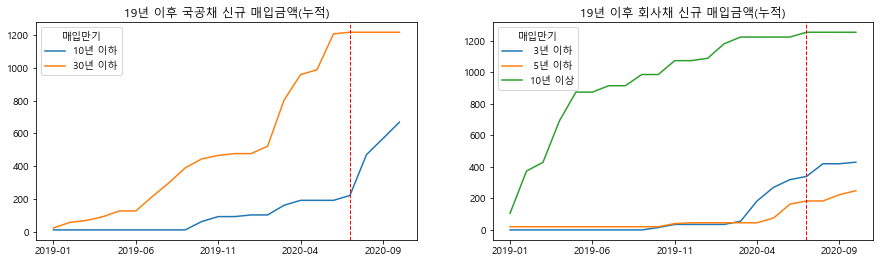

In [ ]:
trade.loc[:,'상품종류'] = trade.loc[:,'상품종류'].replace({'금융채':'회사채', '금융채(특금)':'회사채', '회사채(특금)':'회사채','국채':'국공채',
                                                '지방채':'국공채','공사채':'국공채','국채(첨가)':'국공채','국채(특금)':'국공채'})
x=pd.to_datetime(trade.loc[:,'만기일'])
z=pd.to_datetime(trade.loc[:,'매입일'])
k=x-z
trade.loc[:,'매입만기']=round(k/np.timedelta64(1,'Y'))

comm_gov = trade.loc[:,'상품종류'] == '국공채'
comm_cor = trade.loc[:,'상품종류'] == '회사채'

dur_10_a = (trade.매입만기>10)
dur_10_b = (trade.매입만기<=10)
dur_3_b = (trade.매입만기<=3)
dur_3_5 = (trade.매입만기>3) & (trade.매입만기<=5)
dur_10__a = (trade.매입만기>5)

trade.loc[dur_10_b & comm_gov,'매입만기']='10년 이하'
trade.loc[dur_10_a & comm_gov,'매입만기']='30년 이하'
trade.loc[dur_3_b & comm_cor,'매입만기']=' 3년 이하'
trade.loc[dur_3_5 & comm_cor,'매입만기']=' 5년 이하'
trade.loc[dur_10__a & comm_cor,'매입만기']='10년 이상'
trade_p =trade.pivot_table(index=['상품종류','매입만기'],columns='매입월',values='장부금액',aggfunc='sum',fill_value=0)/100000000
trade_p['2019-06']=0
trade_p=trade_p.T.sort_index().T

trade_net = pd.DataFrame()
for i in range(22) :
    trade_net[trade_p.columns[i]] = trade_p.iloc[:,:i+1].sum(axis=1)
fig = plt.figure(figsize=(15,4))
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)
trade_net.T['국공채'].plot(title='19년 이후 국공채 신규 매입금액(누적)',ax=ax0)
ax0.axvline(x=18, color='r',linestyle='--',linewidth=1)
trade_net.T['회사채'].plot(title='19년 이후 회사채 신규 매입금액(누적)',ax=ax1)
ax1.axvline(x=18, color='r',linestyle='--',linewidth=1)
ax1.legend(title='매입만기',loc=2)
trade_net.T

### 2) 신용등급 및 업종별

업종,기타,농협계열사(보험),여신전문,정유화학
2019-01,0.0,20.1,0.0,105.3
2019-02,54.5,58.4,0.0,281.2
2019-03,54.5,63.7,0.0,331.5
2019-04,105.4,63.7,171.9,372.3
2019-05,155.5,63.7,304.1,372.3
2019-06,155.5,63.7,304.1,372.3
2019-07,155.5,63.7,344.7,372.3
2019-08,155.5,63.7,344.7,372.3
2019-09,155.5,74.5,405.0,372.3
2019-10,170.4,74.5,405.0,372.3


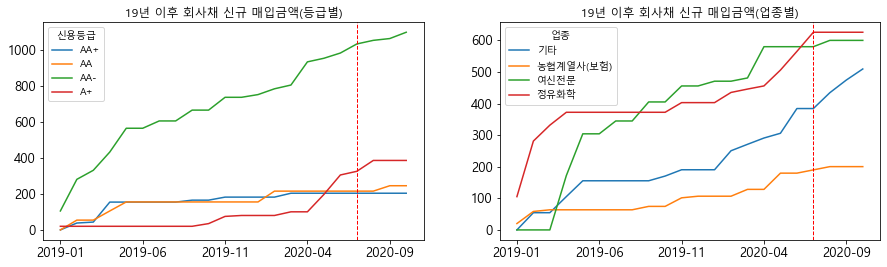

In [ ]:
cred = trade.loc[:,['사무소코드','매입월','계좌번호','상품종류','종목명','장부금액','발행회사(신용등급)']]
cred.loc[:,'상품종류'] = cred.loc[:,'상품종류'].replace({'금융채':'회사채', '금융채(특금)':'회사채', '회사채(특금)':'회사채','국채':'국공채',
                                                '지방채':'국공채','공사채':'국공채','국채(첨가)':'국공채','국채(특금)':'국공채'})
cred = cred[cred.상품종류=='회사채']

data['매입월'] = data['보유일자']
data1 = data
data1.loc[:,'상품종류'] = data1.loc[:,'상품종류'].replace({'금융채':'회사채', '금융채(특금)':'회사채', '회사채(특금)':'회사채','국채':'국공채',
                                                '지방채':'국공채','공사채':'국공채','국채(첨가)':'국공채','국채(특금)':'국공채'})
data1.loc[:,'상품종류'] = data1.loc[:,'상품종류'].replace({'금융채':'회사채', '금융채(특금)':'회사채', '회사채(특금)':'회사채','국채':'국공채',
                                                '지방채':'국공채','공사채':'국공채','국채(첨가)':'국공채','국채(특금)':'국공채'})

data1=data1.loc[(data.상품종류=='회사채')&(data.부실여부=='정상유가증권'),:]

data1=data1.loc[:,['매입월','계좌번호','신용등급']]


mer = cred.merge(data1,on=['매입월','계좌번호']).sort_values('매입월')
mer.loc[:,'발행회사']=mer.loc[:,'발행회사(신용등급)'].str[:-5]
mer_p = mer.pivot_table(values='장부금액',index='매입월',columns='신용등급',aggfunc='sum',fill_value=0)/100000000
a=pd.date_range('2019-01','2020-11',freq='M').strftime('%Y-%m')
mer_p = mer_p.reindex(index=a,fill_value=0)

mer_net = pd.DataFrame(columns=mer_p.columns)
for i in range(22) :
    mer_net.loc[mer_p.index[i],:] = mer_p.iloc[:i+1,:].sum()
mer_net = mer_net.loc[:,['AA+','AA','AA-','A+']]

mer2 = mer.loc[:,['매입월','장부금액','신용등급','발행회사']]

#pd.read_clipboard().to_csv('신규매입 업종.csv')
indus = pd.read_csv('신규매입 업종.csv',usecols=['발행회사','업종'])
mer3 = mer2.merge(indus, on='발행회사').sort_values('매입월')
mer3 = mer3.pivot_table(values='장부금액',index='매입월',columns='업종',aggfunc='sum',fill_value=0)/100000000
mer3 = mer3.reindex(index=a,fill_value=0)

mer_net2 = pd.DataFrame(columns=mer3.columns)
for i in range(22) :
    mer_net2.loc[mer3.index[i],:] = mer3.iloc[:(i+1),:].sum()

fig = plt.figure(figsize=(15,4))
mer_net.plot(title='19년 이후 회사채 신규 매입금액(등급별)',fontsize=13,ax=fig.add_subplot(1,2,1))
plt.axvline(x=18, color='r',linestyle='--',linewidth=1)
mer_net2.plot(title='19년 이후 회사채 신규 매입금액(업종별)',fontsize=13,ax=fig.add_subplot(1,2,2))
plt.axvline(x=18, color='r',linestyle='--',linewidth=1)
mer_net2

## 4. 보유자산 특성별 농축협 수 추이

### 1) 정상유가증권 보유 여부

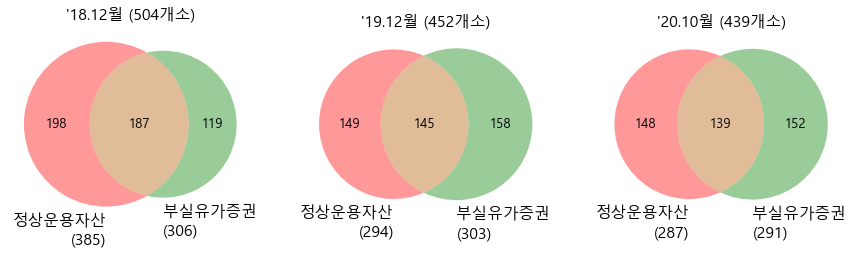

In [ ]:
def grouping3(basedate):
    group = balance_raw.loc[(balance_raw.보유일자==basedate),:]
    group_p = group.pivot_table(values='장부금액',index = ['사무소코드','지역본부','사무소명'],columns=['과목'],
                                aggfunc='sum',margins=True, margins_name='합계',fill_value=0).drop(index='합계')
    group_p = group_p[group_p.합계>0]
    group_p.loc[:,'정상운용자산'] = group_p.loc[:,['수익증권','채권','대내외예치금']].sum(axis=1)

    cond1 = group_p.정상운용자산>0
    cond2 = group_p.부실유가증권>0

    cond_1 = (cond1) & (~cond2)
    cond_2 = (~cond1) & (cond2)
    cond_3 = (cond1) & (cond2)

    group_p.loc[cond_1,'그룹']='1'
    group_p.loc[cond_2,'그룹']='2'
    group_p.loc[cond_3,'그룹']='3'

    group_p2 = group_p.pivot_table(index='그룹',aggfunc='sum').loc[:,['정상운용자산','부실유가증권','합계']]
    group_p2.loc[:,'농축협수'] = group_p.그룹.value_counts().loc[['1','2','3']]
    group_p3 = group_p2.loc[:,'농축협수'].to_list()
    return group_p3

fig=plt.figure(figsize=(15,17))
plt.rc('font', size=13)
ax0 = fig.add_subplot(1,3,1)
plt.title("'18.12월 (504개소)")
ax1 = fig.add_subplot(1,3,2)
plt.title("'19.12월 (452개소)")
ax2 = fig.add_subplot(1,3,3)
plt.title("'20.10월 (439개소)")
x1=grouping3('2018-12-31')
x2=grouping3('2019-12-31')
x3=grouping3('2020-10-21')
ven.venn2(x1, set_labels=('정상운용자산\n(385)','부실유가증권\n(306)'),ax=ax0)
ven.venn2(x2, set_labels=('정상운용자산\n(294)','부실유가증권\n(303)'),ax=ax1)
ven.venn2(x3, set_labels=('정상운용자산\n(287)','부실유가증권\n(291)'),ax=ax2)

## 2) 보유자산 특성별

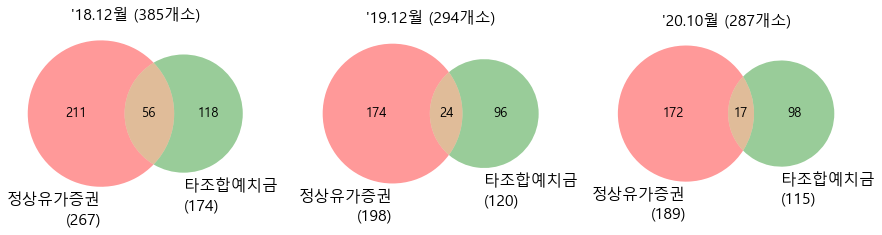

In [ ]:
def grouping4(basedate):
    group = balance_raw.loc[(balance_raw.보유일자==basedate),:]
    group_p = group.pivot_table(values='장부금액',index = ['사무소코드','지역본부','사무소명'],columns=['과목'],
                                aggfunc='sum',margins=True, margins_name='합계',fill_value=0).drop(index='합계')
    group_p.loc[:,'정상운용자산'] = group_p.loc[:,['수익증권','채권','대내외예치금']].sum(axis=1)
    group_p = group_p[group_p.정상운용자산>0]
    group_p.loc[:,'유가증권'] = group_p.loc[:,['수익증권','채권']].sum(axis=1)
    

    cond1 = group_p.유가증권>0
    cond2 = group_p.대내외예치금>0

    cond_1 = (cond1) & (~cond2)
    cond_2 = (~cond1) & (cond2)
    cond_3 = (cond1) & (cond2)

    group_p.loc[cond_1,'그룹']='1'
    group_p.loc[cond_2,'그룹']='2'
    group_p.loc[cond_3,'그룹']='3'

    group_p2 = group_p.pivot_table(index='그룹',aggfunc='sum').loc[:,['유가증권','대내외예치금','합계']]
    group_p2.loc[:,'농축협수'] = group_p.그룹.value_counts().loc[['1','2','3']]
    group_p3 = group_p2.loc[:,'농축협수'].to_list()
    return group_p3

fig=plt.figure(figsize=(15,17))
plt.rc('font', size=13)
ax0 = fig.add_subplot(1,3,1)
plt.title("'18.12월 (385개소)")
ax1 = fig.add_subplot(1,3,2)
plt.title("'19.12월 (294개소)")
ax2 = fig.add_subplot(1,3,3)
plt.title("'20.10월 (287개소)")
x1=grouping4('2018-12-31')
x2=grouping4('2019-12-31')
x3=grouping4('2020-10-21')
ven.venn2(x1, set_labels=('정상유가증권\n(267)','타조합예치금\n(174)'),ax=ax0)
ven.venn2(x2, set_labels=('정상유가증권\n(198)','타조합예치금\n(120)'),ax=ax1)
ven.venn2(x3, set_labels=('정상유가증권\n(189)','타조합예치금\n(115)'),ax=ax2)